In [ ]:
#### Code for Generating LAMMPS Data Files ###

In [1]:
import numpy as np
import random

from collections import namedtuple
from math import cos, sin
from itertools import combinations, chain

from matplotlib import pyplot as plt

In [2]:
#Define Classes

class Bead:
    '''Particle in coarse grained model'''
    def __init__(self, ID=None, type=None, xyz=None):
        self.ID = ID
        self.type = type
        self.xyz = xyz

class Vertex(Bead):
    '''Vertex of honeycomb structure, where multiple cell walls meet.

    label: a 3 element vector indicating the position of the vertex
            1: position in x-direction
            2: position in y-direction, n-th row of cells    
            3: position in vertical wall, -1 for lower, +1 for upper
    arms: a list of cell walls that meet at the vertex
            for a coarse-grained model, also include the immediate cell wall beads
            that bond with the vertex
    '''
    def __init__(self, label, ID=None, type=None, xyz=None) -> None:
            self.label = label
            self.arms = []
            super().__init__(ID, type, xyz)
    def __repr__(self) -> str:
            return f'Vertex({self.label})'

class CellWall:
    '''One cell wall is defined by two vertices at the two ends
    v1: starting vertex
    v2: ending vertex
    cell1/2: lable of the two cells that border at the cell wall
    t: thickness
    '''
    def __init__(self, v1, v2, t=None):
        self.v1, self.v2 = v1, v2
        x1, y1, z1 = v1.label
        x2, y2, z2 = v2.label
        if x1 == x2 and y1 == y2:
            self.cell1, self.cell2 = (x1-1, y1), (x1+1, y1)
        else:
            self.cell1, self.cell2 = (x1, y2), (x2, y1)
        self.t = t

    def __repr__(self) -> str:
        return f'{self.v1}, {self.v2}'

    def cg(self, ninter):
        '''Coarse grain the cell wall into a particle model.'''
        ibeads = []
        vbond = np.subtract(self.v2.xyz, self.v1.xyz) / (ninter + 1)
        r0 = np.linalg.norm(vbond)
        for i in range(ninter):
            randv = np.multiply(0.1*r0, (random.random(), random.random()))
            ibeads.append(Bead(xyz = np.add(self.v1.xyz, (i+1)*vbond + randv)))
        ibonds = [(ibeads[i-1], ibeads[i]) for i in range(1, ninter)]
        ibonds.append((self.v1, ibeads[0]))
        ibonds.append((self.v2, ibeads[-1]))
        self.v1.arms.append((self, ibeads[0]))
        self.v2.arms.append((self, ibeads[-1]))
        iangles = [(ibeads[i-1], ibeads[i], ibeads[i+1]) for i in range(1, ninter-1)]
        iangles.append((self.v1, ibeads[0], ibeads[1]))
        iangles.append((self.v2, ibeads[-1], ibeads[-2]))
        self.ibeads = ibeads
        self.ibonds = ibonds
        self.iangles = iangles

class SuperCell:
    '''Super cell to define the distribution pattern of cell wall thickness.
    n0_super: number of cells along one side of the super cell
    t0: average cell wall thickness
    t_by_layer: thickness of cell walls by layers from the core outwards
    dt: cell wall thickness difference between two adjacent layers from core outwards
    dict_layerID: a dictionary to store the layer assignment of a fiven cell
    dt muse be given if t_by_layer is None, in which case core thickness is assumed 1    
    '''
    def __init__(self, n0_super, t0, t_by_layer=None, dt=None) -> None:
        self.n0_super = n0_super
        self.t0 = t0
        if t_by_layer is None:
            self.t_by_layer = [1+i*dt for i in range(n0_super)]
        else:
            self.t_by_layer = t_by_layer
        self.dict_layerID = {}

    def calc_layerID(self, label):
        '''calculate the layer ID (i.e. distance from core) of a cell with the given label'''
        if label in self.dict_layerID:
            return self.dict_layerID[label]
        x, y = label
        # reduce the label
        x = x % (6*self.n0_super)
        y = (y + self.n0_super) % (2*self.n0_super) - self.n0_super
        # distance to core
        dx = 2*self.n0_super - x
        dy = -y
        abs_dx = abs(dx)
        abs_dy = abs(dy)
        
        if dx == 0:
            delta = abs_dy
        elif dy == 0:
            delta = abs_dx / 2
        else:
            delta = min(abs_dy, abs_dx)
        
            x2 = x + dx / abs_dx * delta
            y2 = y + dy / abs_dy * delta
        
            dx2 = 2*self.n0_super - x2
            dy2 = -y2
        
            if dx2 == 0:
                delta += abs(dy2)
            elif dy2 == 0:
                delta += abs(dx2) / 2
        
        if delta <= self.n0_super:
            delta = int(delta)
            self.dict_layerID[label] = delta
            return delta
        # find image in the super cell if it's still outside
        else:
            if dx < 0:
                dx_sign = -1
            else:
                dx_sign = 1
            if dy < 0:
                dy_sign = -1
            else:
                dy_sign = 1
            x = x + dx_sign * 3*self.n0_super
            y = y + dy_sign * self.n0_super
            return self.calc_layerID((x, y))

    def calc_t_cellwall(self, wall):
        '''Calculate the thickness of a given cell wall.'''
        layer1 = self.calc_layerID(wall.cell1)
        layer2 = self.calc_layerID(wall.cell2)
        return self.t_by_layer[layer1] + self.t_by_layer[layer2]

class Honeycomb:
    def __init__(self, nx, ny, px, py):
        '''A honeycomb structure defined by vertices and cell walls
        
        nx: number of cells in zig-zag (x-) direction
        ny: number of cells in armhair (y-) direction
        px/py: whether periodic boundaries applied in x-/y- directions
        '''
        # initialize list of vertices by rows in armchair direction
        vertices = [[Vertex((2*i-1, 0, 1)) for i in range(nx+1)]]
        for j in range(ny):
            di = j%2
            vertices.append([Vertex((2*i-di, j+1, -1)) for i in range(nx+di)])
            vertices.append([Vertex((2*i-di, j+1,    1)) for i in range(nx+di)])
        if not py:
            j += 1
            di = j%2
            vertices.append([Vertex((2*i-di, j+1, -1)) for i in range(nx+di)])
        self.vertices = vertices # list of vertices by rows in armchair direction

        # list of cell walls
        walls = []
        nrows = len(vertices)
        for j in range(1, nrows, 4):
            for i in range(nx):
                v1 = vertices[j][i]
                v2 = vertices[j-1][i]
                walls.append(CellWall(v1, v2))
                v2 = vertices[j-1][i+1]
                walls.append(CellWall(v1, v2))
        for j in range(3, nrows, 4):
            for i in range(nx):
                v1 = vertices[j-1][i]
                v2 = vertices[j][i]
                walls.append(CellWall(v1, v2))
                v2 = vertices[j][i+1]
                walls.append(CellWall(v1, v2))
        for j in range(2, nrows, 2):
            for i in range(nx):
                v1 = vertices[j-1][i]
                v2 = vertices[j][i]
                walls.append(CellWall(v1, v2))
        if not px:
            for j in range(4, nrows, 4):
                v1 = vertices[j-1][nx]
                v2 = vertices[j][nx]
                walls.append(CellWall(v1, v2))
        self.walls = walls # list of walls defined by two terminal vertices

        self.nx = nx
        self.ny = ny
        self.px = px
        self.py = py

    def apply_cellwall_length(self, r):
        self.r = r
        cos30 = 3**0.5 / 2
        for vertex in chain(*self.vertices):
            randv = np.multiply(0.1*r, (random.random(), random.random()))
            vertex.xyz = np.multiply(
                r, (cos30*vertex.label[0], 1.5*vertex.label[1]-0.5+0.5*vertex.label[2])
            ) + randv

    def apply_supercell(self, supercell):
        walls_by_t = {}
        for wall in self.walls:
            t = supercell.calc_t_cellwall(wall)
            _ = walls_by_t.setdefault(t, [])
            _.append(wall)
        # normalize the mass of the honeycomb
        mass = sum((t*len(walls) for t, walls in walls_by_t.items()))
        nfactor = supercell.t0*len(self.walls) / mass
        
        self.walls_by_t = {}
        for t, walls in walls_by_t.items():
            t = t*nfactor
            for wall in walls:
                wall.t = t
            self.walls_by_t[t] = walls

    def cg(self, ninter, data_file, E=1, rho=1):
        '''Coarse grain the whole honeycomb.
        ninter: number of beads between vertices
        data_file: path to store the lammps data file
        E: elastic modulus of the cell wall material
        rho: density of the cell wall material
        '''
        r0 = self.r/(ninter+1)
        beads = []
        bonds = []
        angles = []
        btypes = []
        masses = []
        ljs = []
        bdtypes = []
        agtypes = []
        # initialize vertex features
        for vertex in chain(*self.vertices):
            vertex.arms = []
        # coarse grain by walls
        for wall in self.walls:
            wall.cg(ninter)

        # assign IDs, update arms for vertices at boundaries
        nbeads = 0
        nrows = len(self.vertices)
        if self.py: nrows -= 1

        for j in range(nrows):
            for i in range(self.nx):
                nbeads += 1
                v = self.vertices[j][i]
                v.ID = nbeads
                beads.append(v)
        if self.px: # last column is virtual
            for j in range(0, nrows, 4):
                v1 = self.vertices[j][0]
                v2 = self.vertices[j][-1]
                v1.arms.extend(v2.arms)
                v2.ID = v1.ID
            for j in range(3, nrows, 4):
                v1 = self.vertices[j][0]
                v2 = self.vertices[j][-1]
                v1.arms.extend(v2.arms)
                v2.ID = v1.ID
        else:    # last column not virtual
            for j in range(0, nrows, 4):
                nbeads += 1
                v = self.vertices[j][-1]
                v.ID = nbeads
                beads.append(v)
            for j in range(3, nrows, 4):
                nbeads += 1
                v = self.vertices[j][-1]
                v.ID = nbeads
                beads.append(v)
        if self.py:
            for i, v1 in enumerate(self.vertices[0]):
                v2 = self.vertices[-1][i]
                v1.arms.extend(v2.arms)
                v2.ID = v1.ID

        n_vertex_beads = nbeads # number of vertex beads
        vertices_by_t = {} # vertices grouped by size
        vangles_by_t = {}    # vertex angles grouped by thickness
        for v in beads:
            for a1, a2 in combinations(v.arms, 2):
                w1, b1 = a1
                w2, b2 = a2
                t1 = w1.t
                t2 = w2.t
                t = t1*t2/((t1**3+t2**3)/2)**(1/3)
                _ = vangles_by_t.setdefault(t, [])
                _.append((b1, v, b2))

            t = sum((w.t for w, _ in v.arms))
            t = t/2
            _ = vertices_by_t.setdefault(t, [])
            _.append(v)

        nbtypes = 0
        nbdtypes = 0
        nagtypes = 0
        # 456*epsilon/sigma^2 = E/t*b*r0
        # epsilon = E*sigma^2/t*b*r0 / 456 = E*sigma^2*r0/t
        for t, vertices in vertices_by_t.items():
            nbtypes += 1
            mass = rho*r0*t
            masses.append(mass)
            _t = r0
            sigma = _t/2**(1/6)
            epsilon = E*sigma**2*r0/_t / (4*(156/2**(7/3) - 42/2**(7/6)))
            ljs.append((epsilon, sigma, _t))
            for v in vertices:
                v.type = nbtypes

        for t, walls in self.walls_by_t.items():
            nbtypes += 1
            mass = rho*r0*t
            masses.append(mass)
            _t = r0
            sigma = _t/2**(1/6)
            epsilon = E*sigma**2*r0/_t / (4*(156/2**(7/3) - 42/2**(7/6)))
            ljs.append((epsilon, sigma, _t))
            nbdtypes += 1
            bdtypes.append((E*t/2/r0, r0))
            nagtypes += 1
            agtypes.append((E*t**3/12/2/r0, 180))
            for wall in walls:
                for b in wall.ibeads:
                    nbeads += 1
                    b.ID = nbeads
                    b.type = nbtypes
                    beads.append(b)

                for b1, b2 in wall.ibonds:
                    bonds.append((nbdtypes, b1.ID, b2.ID))

                for b1, b2, b3 in wall.iangles:
                    angles.append((nagtypes, b1.ID, b2.ID, b3.ID))

        for t, ags in vangles_by_t.items():
            nagtypes += 1
            agtypes.append((E*t**3/12/2/r0, 120))
            for b1, b2, b3 in ags:
                angles.append((nagtypes, b1.ID, b2.ID, b3.ID))

        print('timestep:', (2*rho/E)**0.5*r0, 'nanosceond')
     
        with open(data_file, 'w') as f:
            xlo = -3**0.5/2*(self.r + 0.5*r0)
            xhi = 3**0.5*self.r*self.nx + xlo
            if not self.px: 
                xhi += 0.5*self.r 
                xlo -= 0.5*self.r 
            ylo = 0
            yhi = self.ny*1.5*self.r+0.5*self.r 
            if not self.py: 
                yhi += 0.5*self.r
                ylo -= 0.5*self.r
                
            f.write('\n')
            f.write(f'{nbeads} atoms\n')
            f.write(f'{len(bonds)} bonds\n')
            f.write(f'{len(angles)} angles\n')
            f.write(f'{nbtypes} atom types\n')
            f.write(f'{nbdtypes} bond types\n')
            f.write(f'{nagtypes} angle types\n')
            f.write('\n')
            f.write(f'{xlo} {xhi} xlo xhi\n')
            f.write(f'{ylo} {yhi} ylo yhi\n')
            f.write(f'{-self.r} {self.r} zlo zhi\n')
            f.write('\n')
            f.write('\nMasses\n\n')
            for i, mass in enumerate(masses):
                f.write(f'{i+1} {mass}\n')
            f.write('\nPair Coeffs\n\n')
            for i, (epsilon, sigma, cut) in enumerate(ljs):
                f.write(f'{i+1} {epsilon} {sigma} {cut}\n')
            f.write('\nBond Coeffs\n\n')
            for i, (K, _r0) in enumerate(bdtypes):
                f.write(f'{i+1} {K} {_r0}\n')
            f.write('\nAngle Coeffs\n\n')
            for i, (K, _t0) in enumerate(agtypes):
                f.write(f'{i+1} {K} {_t0}\n')
            f.write('\nAtoms\n\n')
            for b in beads:
                x, y = b.xyz
                f.write(f'{b.ID} 1 {b.type} {x} {y} 0\n')
            f.write('\nBonds\n\n')
            for i, (t, a1, a2) in enumerate(bonds):
                f.write(f'{i+1} {t} {a1} {a2}\n')
            f.write('\nAngles\n\n')
            for i, (t, a1, a2, a3) in enumerate(angles):
                f.write(f'{i+1} {t} {a1} {a2} {a3}\n')

In [ ]:
### Code for Defining Structure Generation from Genes ###

In [3]:
def Random_Generate_Honeycomb():
    #Random periodicity for superlattice
    scell_max = 10 #can change for different max periodicity size
    num_list = []  
    scell = random.randint(2,scell_max) 
    num_list.append(scell)
    
    for count in range(scell):
        num_list.append(random.randint(2,15)) # cell wall thickness list
    for count in range(scell_max-scell):
        num_list.append(int(0))
    return num_list   

def gene2name(num_list):#Set filename from gene
    name = ""
    for i in num_list:
        name+=str(i)+','
    name = name.rstrip(name[-1])
    return name

def name2gene(name):#Read filename to gene
    genename=name.split(',')
    gene = [int(i) for i in genename]
    return gene

timestep: 0.00223606797749979 nanosceond


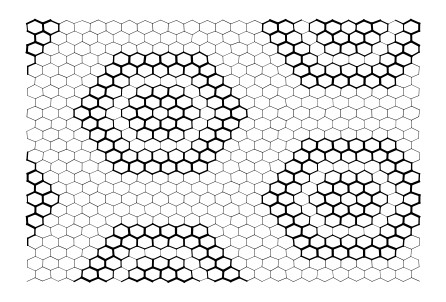

timestep: 0.00223606797749979 nanosceond


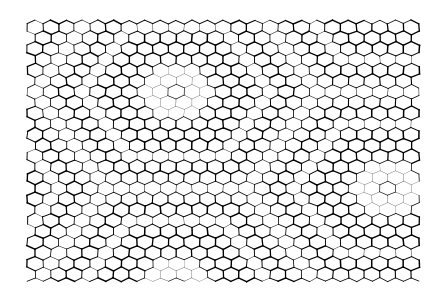

timestep: 0.00223606797749979 nanosceond


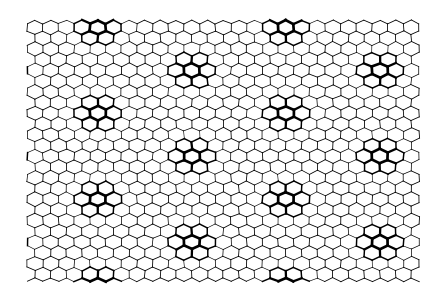

timestep: 0.00223606797749979 nanosceond


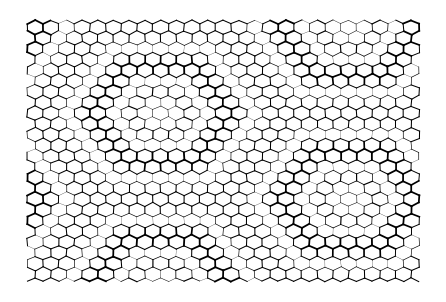

timestep: 0.00223606797749979 nanosceond


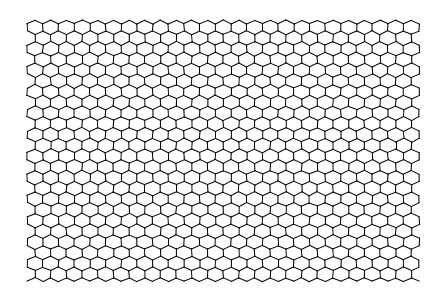

timestep: 0.00223606797749979 nanosceond


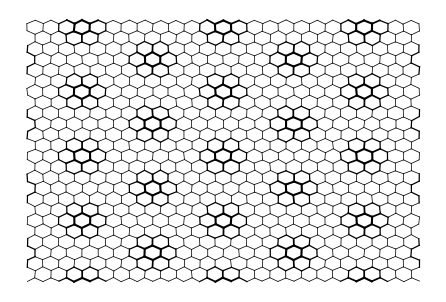

timestep: 0.00223606797749979 nanosceond


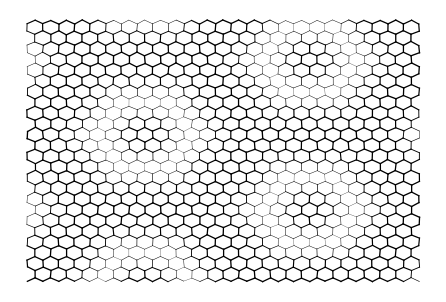

timestep: 0.00223606797749979 nanosceond


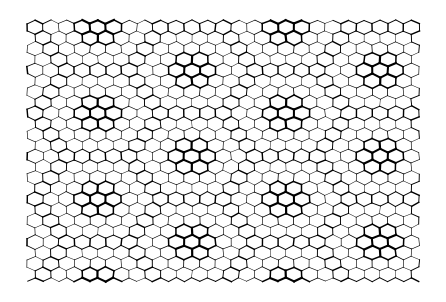

timestep: 0.00223606797749979 nanosceond


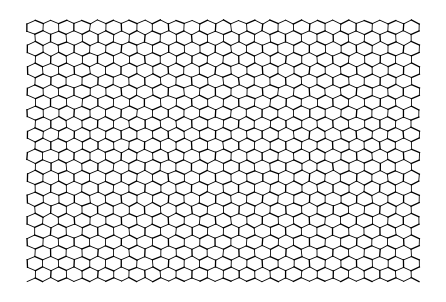

timestep: 0.00223606797749979 nanosceond


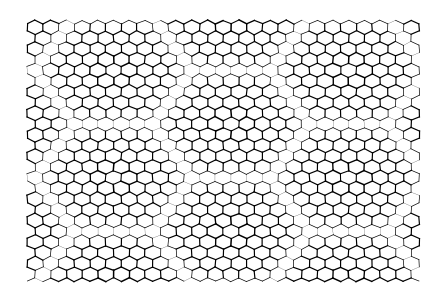

timestep: 0.00223606797749979 nanosceond


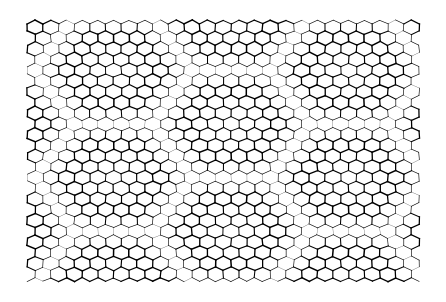

timestep: 0.00223606797749979 nanosceond


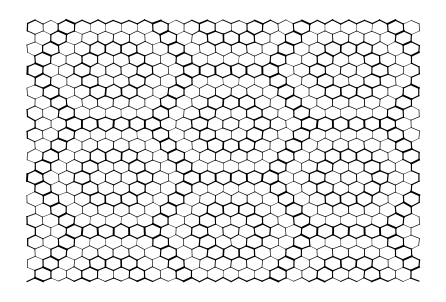

timestep: 0.00223606797749979 nanosceond


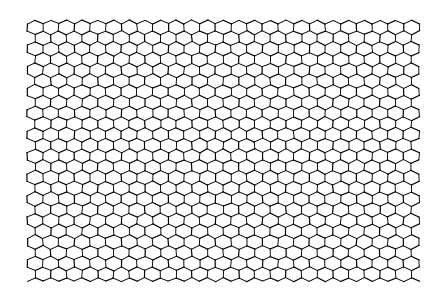

timestep: 0.00223606797749979 nanosceond


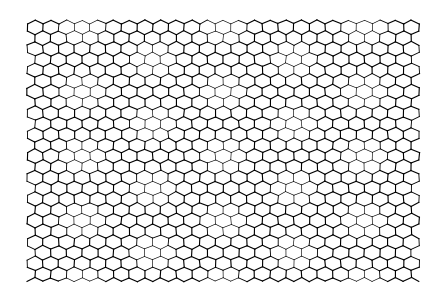

timestep: 0.00223606797749979 nanosceond


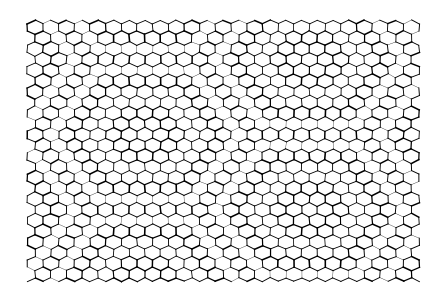

timestep: 0.00223606797749979 nanosceond


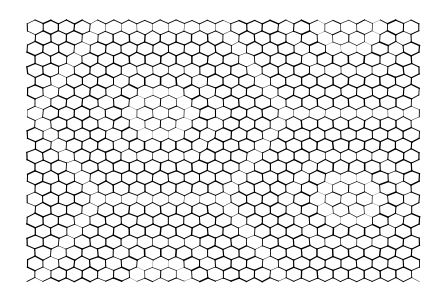

timestep: 0.00223606797749979 nanosceond


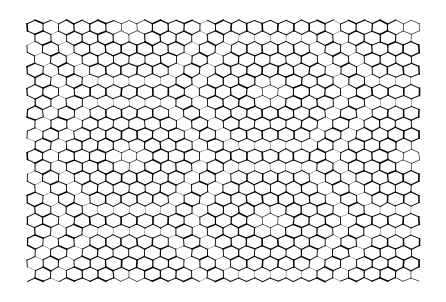

timestep: 0.00223606797749979 nanosceond


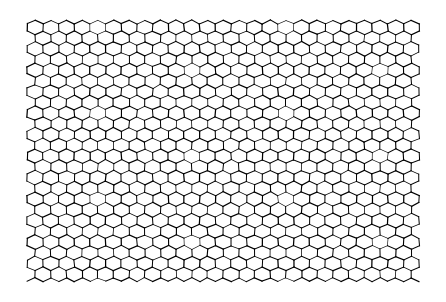

timestep: 0.00223606797749979 nanosceond


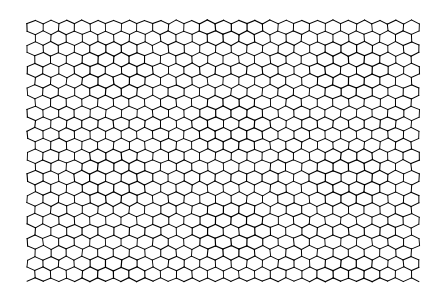

timestep: 0.00223606797749979 nanosceond


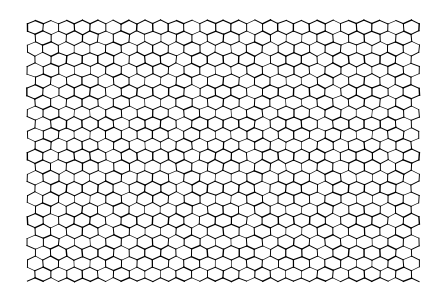

timestep: 0.00223606797749979 nanosceond


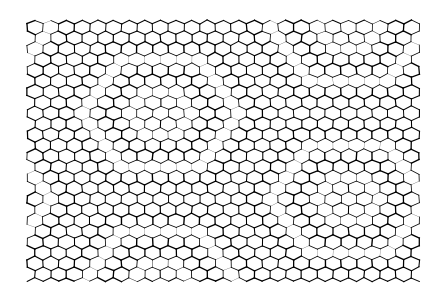

timestep: 0.00223606797749979 nanosceond


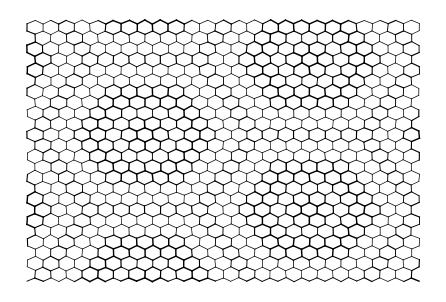

timestep: 0.00223606797749979 nanosceond


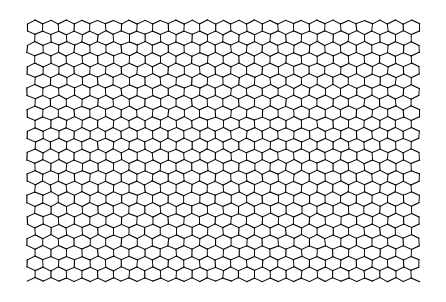

timestep: 0.00223606797749979 nanosceond


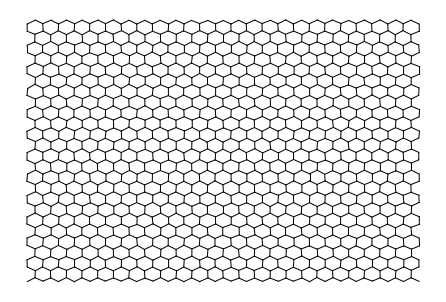

timestep: 0.00223606797749979 nanosceond


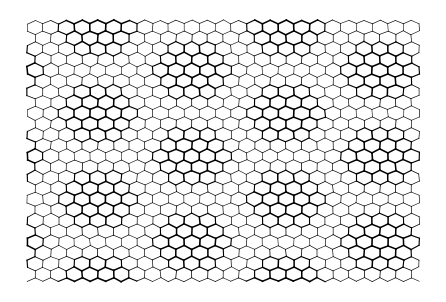

timestep: 0.00223606797749979 nanosceond


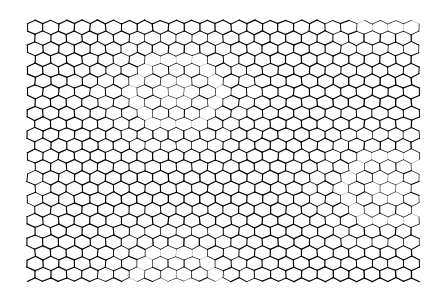

timestep: 0.00223606797749979 nanosceond


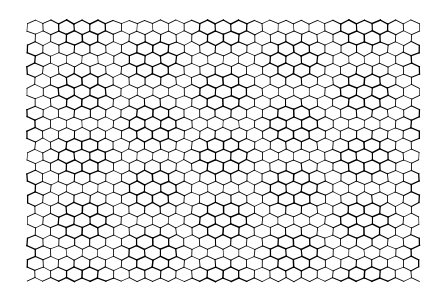

timestep: 0.00223606797749979 nanosceond


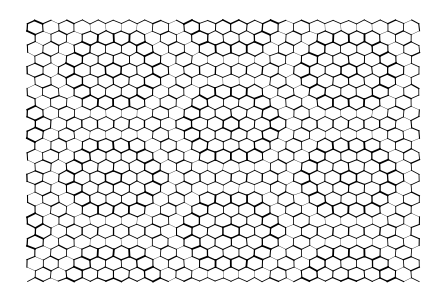

timestep: 0.00223606797749979 nanosceond


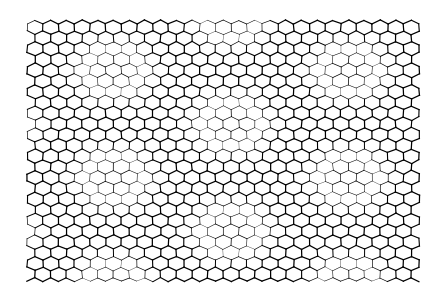

timestep: 0.00223606797749979 nanosceond


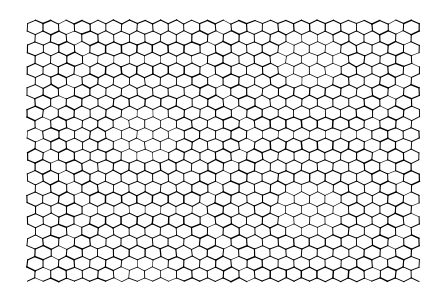

timestep: 0.00223606797749979 nanosceond


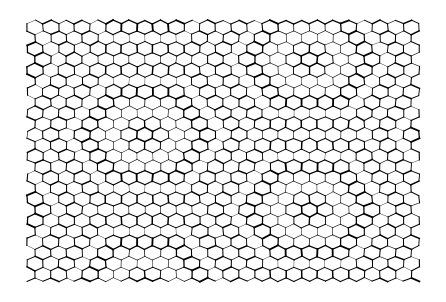

timestep: 0.00223606797749979 nanosceond


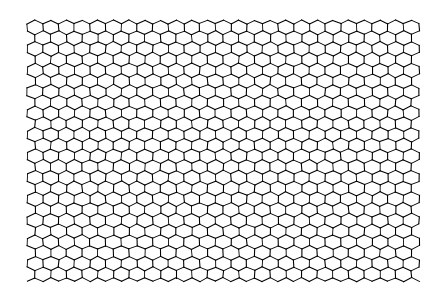

timestep: 0.00223606797749979 nanosceond


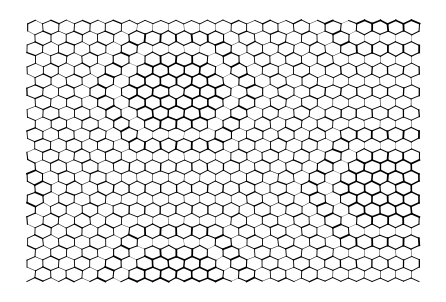

timestep: 0.00223606797749979 nanosceond


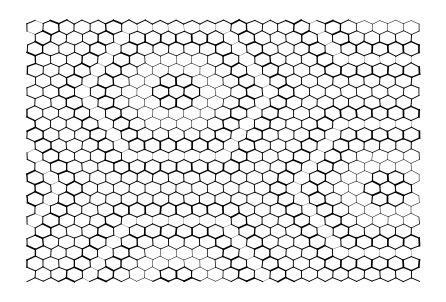

timestep: 0.00223606797749979 nanosceond


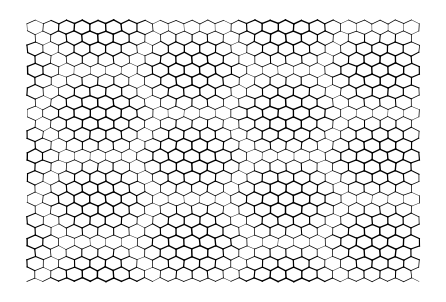

timestep: 0.00223606797749979 nanosceond


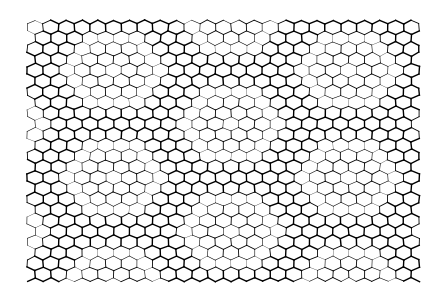

timestep: 0.00223606797749979 nanosceond


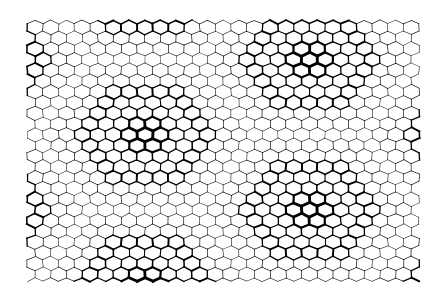

timestep: 0.00223606797749979 nanosceond


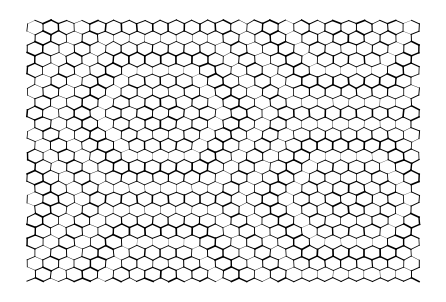

timestep: 0.00223606797749979 nanosceond


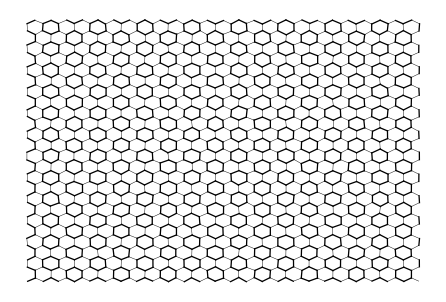

timestep: 0.00223606797749979 nanosceond


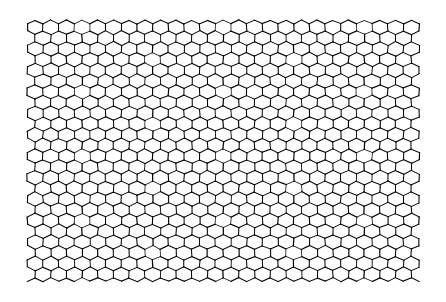

timestep: 0.00223606797749979 nanosceond


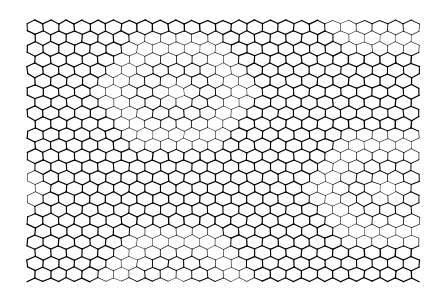

timestep: 0.00223606797749979 nanosceond


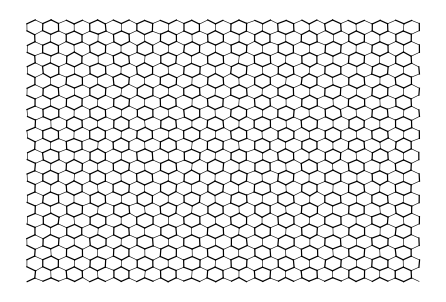

timestep: 0.00223606797749979 nanosceond


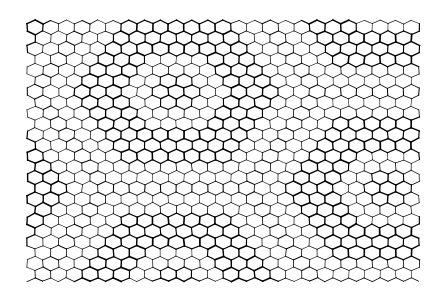

timestep: 0.00223606797749979 nanosceond


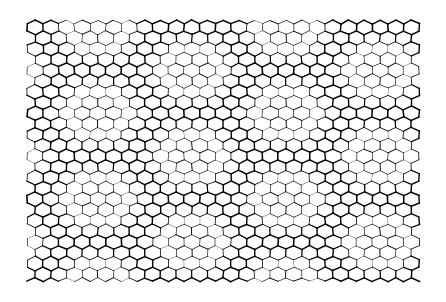

timestep: 0.00223606797749979 nanosceond


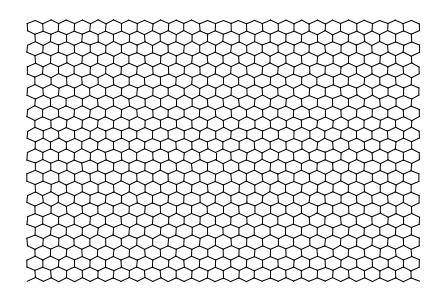

timestep: 0.00223606797749979 nanosceond


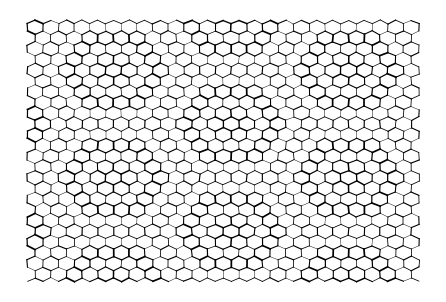

timestep: 0.00223606797749979 nanosceond


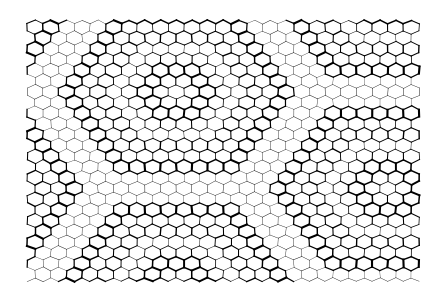

timestep: 0.00223606797749979 nanosceond


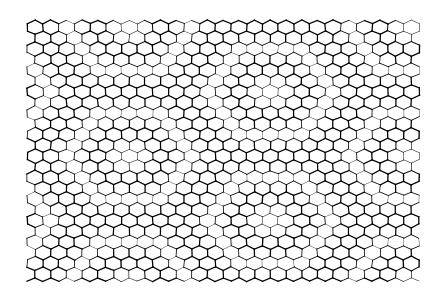

timestep: 0.00223606797749979 nanosceond


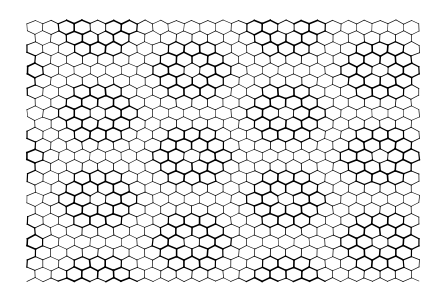

timestep: 0.00223606797749979 nanosceond


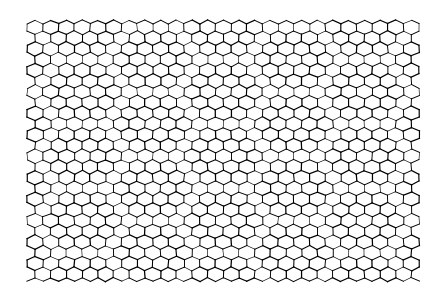

In [4]:
#Make a Bunch of Structures

import os,random

random.seed(1234) 
cases = 50 # generating cases number of samples

for c in range(0,cases): 
    os.makedirs('D:/MIT/LAMM/superhoneycomb/datafiles_0927_', exist_ok=True)
    #Use the nano unit system in lammps in default
    
    #Random Generate Honeycomb
    gene = Random_Generate_Honeycomb()
    name = gene2name(gene)
    
    #Honeycomb parameters
    t0 = 1 #Can alter to change average cell wall thickness
    r = 4 #Can alter to change average cell wall length
    n0_super = gene.pop(0)-1
    num_list = gene[0:n0_super+1]
    t_by_layer = num_list[::-1] 
    
    #Sample size
    nx = int(100/r) 
    ny = nx-1
    px = False # periodicity in x
    py = px # periodicity in y
    ninter = 7 # number of beads to coarse grain cell wall
    data_file = 'D:/MIT/LAMM/superhoneycomb/datafiles_0927_/dat.'+name #'MD/honeycomb/data/dat.'+name
    E = 100 # attogram/(nm*ns^2) = MPa
    rho = 0.001 # attogram/nm^3 = 10^6 kg/m^3
    
    #Generate honeycomb
    h = Honeycomb(nx, ny, px, py)
    sc = SuperCell(n0_super, t0, t_by_layer)
    h.apply_cellwall_length(r)
    h.apply_supercell(sc)
    try:
        h.cg(ninter, data_file, E, rho)
    except:
        continue

    for wall in h.walls:
        x1, y1 = wall.v1.xyz
        x2, y2 = wall.v2.xyz
        plt.plot([x1, x2], [y1, y2], linewidth=wall.t, c='k')
    plt.axis('off')
    plt.tight_layout(pad=0)
    #plt.savefig('MD/honeycomb/data/'+name+'.png') #'honeycomb'+str(c)+'.png')
    plt.show()         

In [ ]:
#### Code for .png to .stl ###

In [9]:
import numpy as np
import glob
import pandas as pd
import struct

In [10]:
ASCII_FACET = """facet normal 0 0 0
outer loop
vertex {face[0][0]:.4f} {face[0][1]:.4f} {face[0][2]:.4f}
vertex {face[1][0]:.4f} {face[1][1]:.4f} {face[1][2]:.4f}
vertex {face[2][0]:.4f} {face[2][1]:.4f} {face[2][2]:.4f}
endloop
endfacet
"""

BINARY_HEADER ="80sI"
BINARY_FACET = "12fH"

class ASCII_STL_Writer:
    """ Export 3D objects build of 3 or 4 vertices as ASCII STL file.
    """
    def __init__(self, stream):
        self.fp = stream
        self._write_header()

    def _write_header(self):
        self.fp.write("solid python\n")

    def close(self):
        self.fp.write("endsolid python\n")

    def _write(self, face):
        self.fp.write(ASCII_FACET.format(face=face))

    def _split(self, face):
        p1, p2, p3, p4 = face
        return (p1, p2, p3), (p3, p4, p1)

    def add_face(self, face):
        """ Add one face with 3 or 4 vertices. """
        if len(face) == 4:
            face1, face2 = self._split(face)
            self._write(face1)
            self._write(face2)
        elif len(face) == 3:
            self._write(face)
        else:
            raise ValueError('only 3 or 4 vertices for each face')

    def add_faces(self, faces):
        """ Add many faces. """
        for face in faces:
            self.add_face(face)

class Binary_STL_Writer(ASCII_STL_Writer):
    """ Export 3D objects build of 3 or 4 vertices as binary STL file.
    """
    def __init__(self, stream):
        self.counter = 0
        super(Binary_STL_Writer, self).__init__(stream)

    def close(self):
        self._write_header()

    def _write_header(self):
        self.fp.seek(0)
        self.fp.write(struct.pack(BINARY_HEADER, b'Python Binary STL Writer', self.counter))

    def _write(self, face):
        self.counter += 1
        data = [
            0., 0., 0.,
            face[0][0], face[0][1], face[0][2],
            face[1][0], face[1][1], face[1][2],
            face[2][0], face[2][1], face[2][2],
            0
        ]
        self.fp.write(struct.pack(BINARY_FACET, *data))


def example():
    def get_cube():
        # cube corner points
        s = 3.
        p1 = (0, 0, 0)
        p2 = (0, 0, s)
        p3 = (0, s, 0)
        p4 = (0, s, s)
        p5 = (s, 0, 0)
        p6 = (s, 0, s)
        p7 = (s, s, 0)
        p8 = (s, s, s)

        # define the 6 cube faces
        # faces just lists of 3 or 4 vertices
        return [
            [p1, p5, p7, p3],
            [p1, p5, p6, p2],
            [p5, p7, p8, p6],
            [p7, p8, p4, p3],
            [p1, p3, p4, p2],
            [p2, p6, p8, p4],
        ]

    with open('cube.stl', 'wb') as fp:
        writer = Binary_STL_Writer(fp)
        writer.add_faces(get_cube())
        writer.close()


In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def png2composite(inputName, ratio = 10, thick=2): #ratio is for smoothing the geometry
    img = cv2.imread(inputName, cv2.IMREAD_GRAYSCALE)
    print(img.shape)
    img = cv2.resize(img, (img.shape[1]*ratio, img.shape[0]*ratio), interpolation= cv2.INTER_LINEAR)
    img[15*ratio-2:15*ratio+2,:4*ratio] = 0
    plt.imshow(img)
    img=np.around(img/255)
    composite = dict()
    
    def get_model():
        for i in range(0, img.shape[0]):
            for j in range(0, img.shape[1]):
                if i >= 15*ratio-2 and i < 15*ratio+2 and j < 4*ratio:
                    continue
                if (img[i][j] not in composite):
                    composite[img[i][j]] = []
                face1 = [(i/ratio, j/ratio, 0), (i/ratio, (j+1)/ratio, 0), ((i+1)/ratio, (j+1)/ratio, 0), ((i+1)/ratio, j/ratio, 0)]
                face2 = [(i/ratio, j/ratio, thick), ((i+1)/ratio, j/ratio, thick), ((i+1)/ratio, (j+1)/ratio, thick), (i/ratio, (j+1)/ratio, thick)]
                composite[img[i][j]].append(face1)
                composite[img[i][j]].append(face2)
                
                if(j==0):
                    composite[img[i][j]].append([face1[0], face1[3], face2[1], face2[0]])
                if(i==0):
                    composite[img[i][j]].append([face1[1], face1[0], face2[0], face2[3]])
                if(j==img.shape[1]-1):
                    composite[img[i][j]].append([face1[2], face1[1], face2[3], face2[2]])
                if(i==img.shape[0]-1):
                    composite[img[i][j]].append([face1[3], face1[2], face2[2], face2[1]])
                try:
                    if(img[i][j] != img[i][j-1]):
                        composite[img[i][j]].append([face1[0], face1[3], face2[1], face2[0]])
                except:
                    pass
                try:
                    if(img[i][j] != img[i-1][j]):
                        composite[img[i][j]].append([face1[1], face1[0], face2[0], face2[3]])
                except:
                    pass
                try:
                    if(img[i][j] != img[i][j+1]):
                        composite[img[i][j]].append([face1[2], face1[1], face2[3], face2[2]])
                except:
                    pass
                try:
                    if(img[i][j] != img[i+1][j]):
                        composite[img[i][j]].append([face1[3], face1[2], face2[2], face2[1]])
                except:
                    pass
   
        print('collection of coordinates done')
        return composite
    composite = get_model()
    for i, c in enumerate(composite.values()):
        with open(inputName[:-4]+'_'+str(i)+'.stl', 'wb') as fp:
            writer = Binary_STL_Writer(fp)
            writer.add_faces(c)
            writer.close()

['image_data\\test.png', 'image_data\\test2.png'] 2
(288, 432)
collection of coordinates done
(288, 432)
collection of coordinates done


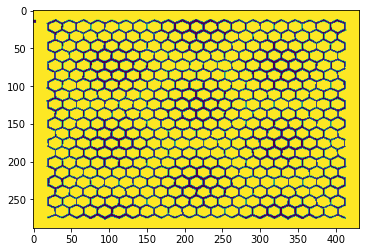

In [15]:
dataset = 'image_data/'
data_list = glob.glob(dataset+'*.png')
data_list.sort(key=lambda f: f.split(dataset)[-1])
print(data_list, len(data_list))

for fname in data_list:
    stl=png2composite(fname, ratio=1)
